Solaris installation with gdal\
!add-apt-repository ppa:ubuntugis/ppa -y\
!apt-get update\
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [1]:
!pip3 install torch torchvision
!pip3 install py7zr
!pip3 install rasterio
!pip3 install --upgrade earthpy

     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 1.9MB 20.3MB/s 
     |████████████████████████████████| 122kB 34.0MB/s 
     |████████████████████████████████| 2.2MB 51.4MB/s 
     |████████████████████████████████| 19.1MB 330kB/s 
     |████████████████████████████████| 1.4MB 15.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0MB 60.3MB/s 
     |████████████████████████████████| 15.3MB 55.4MB/s 
     |████████████████████████████████| 6.5MB 59.0MB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp37-none-any.whl size=1365089 sha256=a320a6dcdda5c4e51b373bc22bcbd5c52ade256fdd54cd8fdeedf40ea80d5284
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


Solaris installation

In [2]:
!add-apt-repository ppa:ubuntugis/ppa -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [15.9 kB]
Get:10 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu bionic InRelease [20.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:13 https://developer.download.

In [3]:
#python imports
import py7zr
import os
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt

#earth observation python lib imports
import rasterio
import solaris as sol
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

#pytorch imports
import torch
from torch import nn
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


load dataset from github\
repo path : https://github.com/AnupamaRajkumar/LandfillDataset.git


In [5]:
#!apt-get update && apt-get upgrade
#!apt-get install git-lfs

Use this if downloading from git (ie. LFS quota available!)

In [6]:
#!git lfs clone https://github.com/AnupamaRajkumar/LandfillDataset.git

Declaring paths

In [7]:

#All the paths related to multispectral dataset
Multispectral_path = './Multispectral.7z'                                       #path of zip files
TIF_file_path = './MultiSpectral/HR_TIF_Files.7z'
JSON_file_path = './MultiSpectral/LandfillCoordPolygons.7z'
json_path = './LandfillCoordPolygons'
train_path = './HR_TIF_Files'
#train_labels = './MultiSpectral/MultiSpectralData.csv'

#All the paths related to pansharpened datset
Pansharpened_path = './Pansharpened.7z'
PanSharpened_TIF_file_path = './Pansharpened/HR_TIF_Files.7z'
PanSharpened_JSON_file_path = './Pansharpened/LandfillCoordPolygons.7z'
train_labels = './Pansharpened/PanSharpenedData.csv'
#Output directory path
out_path = './'                                                                 #output path of extracted files

#dimensions of the figure to be displayed
width = 15
height = 15
num_images = 6

Extract the images from zip folder

In [8]:
def ExtractFiles(in_path, out_path):
  with py7zr.SevenZipFile(in_path, mode='r') as z:
    z.extractall(out_path)

Use following functions downloading dataset from dropbox

Multispectral dataset

In [9]:
def DownloadMultiSpectralDataset():
  !wget https://www.dropbox.com/s/2r0b8goiytyh0fc/MultiSpectral.7z?dl=0
  os.rename('MultiSpectral.7z?dl=0', 'Multispectral.7z')
  ExtractFiles('Multispectral.7z', out_path)

Pansharpened dataset

In [10]:
def DownloadPanSharpenedDataset():
  !wget https://www.dropbox.com/s/y048lu2ehtsmo3r/Pansharpened.7z?dl=0
  os.rename('Pansharpened.7z?dl=0', 'Pansharpened.7z')
  ExtractFiles('Pansharpened.7z', out_path)
  #os.rmdir(Pansharpened_path)

In [11]:
def DownloadPreTrainedModels():
  !wget https://www.dropbox.com/s/aysve9jphkm5yva/PreTrainedModels.7z?dl=0
  os.rename('PreTrainedModels.7z?dl=0', 'PreTrainedModels.7z')
  ExtractFiles('PreTrainedModels.7z', out_path)

In [12]:
DownloadPanSharpenedDataset()
#DownloadMultiSpectralDataset()

--2021-05-04 06:21:02--  https://www.dropbox.com/s/y048lu2ehtsmo3r/Pansharpened.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y048lu2ehtsmo3r/Pansharpened.7z [following]
--2021-05-04 06:21:02--  https://www.dropbox.com/s/raw/y048lu2ehtsmo3r/Pansharpened.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce6783d9d03f0e13cb82ec09404.dl.dropboxusercontent.com/cd/0/inline/BN2Vh72oMHQl9kIW9XI0LbJczJa1bhg5yfJf1QyHBlbKCn628vhjETtsoaFZu3UvnZzqhSrJhXPtDcKHtzlHFUKjoUe8XIhxMmyyCeM3CpnasO8pfUsZIoJylZVUVk1u8VaK3yKOVBVLbNX_xnHgWa08/file# [following]
--2021-05-04 06:21:02--  https://uce6783d9d03f0e13cb82ec09404.dl.dropboxusercontent.com/cd/0/inline/BN2Vh72oMHQl9kIW9XI0LbJczJa1bhg5yfJf1QyHBlbKCn628vhjETtsoaFZu3UvnZzqhSrJh

In [13]:
DownloadPreTrainedModels()

--2021-05-04 06:21:18--  https://www.dropbox.com/s/aysve9jphkm5yva/PreTrainedModels.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/aysve9jphkm5yva/PreTrainedModels.7z [following]
--2021-05-04 06:21:18--  https://www.dropbox.com/s/raw/aysve9jphkm5yva/PreTrainedModels.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc7e2845d1d233c0fe81346d278.dl.dropboxusercontent.com/cd/0/inline/BN3F3m8PEmtlHLN6_4EX1ecY4HDrjeu2oQw7NYftXtjYVTnpfIo85-bgCukCh7QYLM-7Hxb2hWJ9YtF_UOGtifbY-uMnmGzw6Hxua-FCSahoGL6NO5oD0hhqOwijABs9vQporOtpE39awPmhX3rPvGN7/file# [following]
--2021-05-04 06:21:18--  https://ucc7e2845d1d233c0fe81346d278.dl.dropboxusercontent.com/cd/0/inline/BN3F3m8PEmtlHLN6_4EX1ecY4HDrjeu2oQw7NYftXtjYVTnpfIo85-bgCukCh

Extracting the multispectral dataset\
Run this cell if working with multispectral dataset

In [14]:
"""
#extract multispectral images
ExtractFiles(TIF_file_path , out_path)
#extract multispectral json files
ExtractFiles(JSON_file_path , out_path)
"""

'\n#extract multispectral images\nExtractFiles(TIF_file_path , out_path)\n#extract multispectral json files\nExtractFiles(JSON_file_path , out_path)\n'

Extracting the pansharpened dataset\
Run this cell if working with pansharpened dataset

In [15]:

#extract pansharpened images
ExtractFiles(PanSharpened_TIF_file_path , out_path)
#extract multispectral json files
ExtractFiles(PanSharpened_JSON_file_path , out_path)


In [16]:
def im_convert(image_name, channels):
  image = rasterio.open(os.path.join(train_path, image_name)).read()
  #false color composite visualisation
  if(channels == 8):
    raster = np.dstack((image[4,:,:], image[2,:,:],image[1,:,:])) 
  elif(channels == 4):
    raster = np.dstack((image[2,:,:], image[1,:,:],image[0,:,:]))
  return raster

Displaying a few images from the folder

Number of images images: 242
-------------multispectral images----------------
image :  00104_Hannover_Germany.tif channels : 8


<Figure size 1800x1800 with 0 Axes>

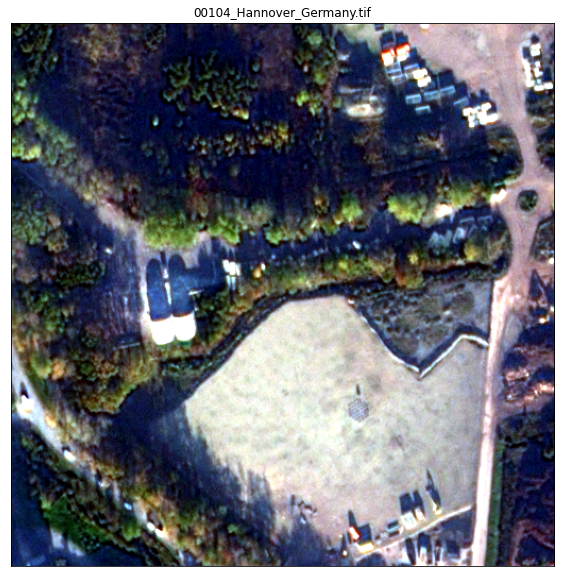

image :  00097_God_Hungary.tif channels : 8


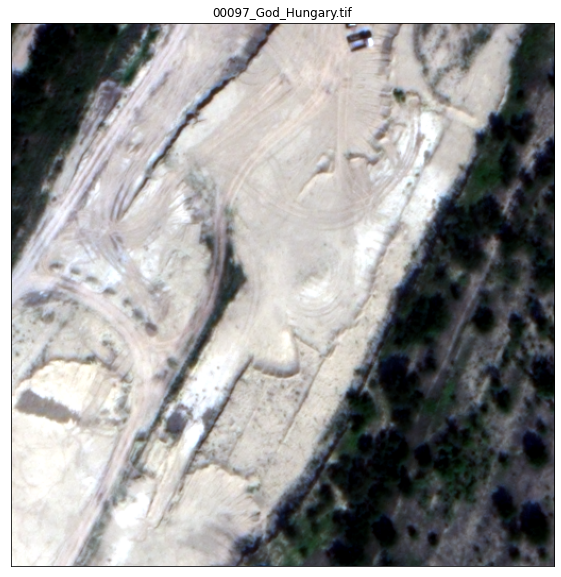

image :  00229_Vinca_Serbia.tif channels : 8


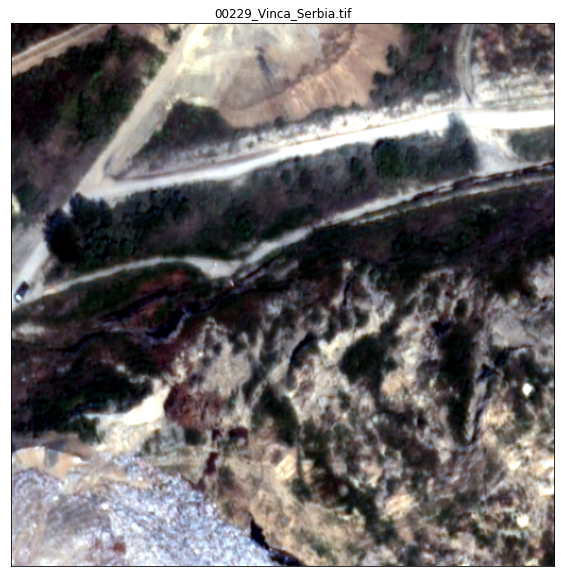

image :  00160_Mumbai_India.tif channels : 4


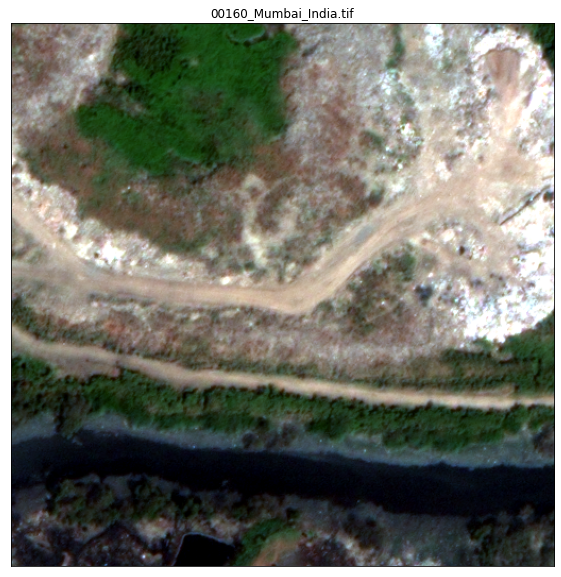

image :  00031_Erd_Hungary.tif channels : 8


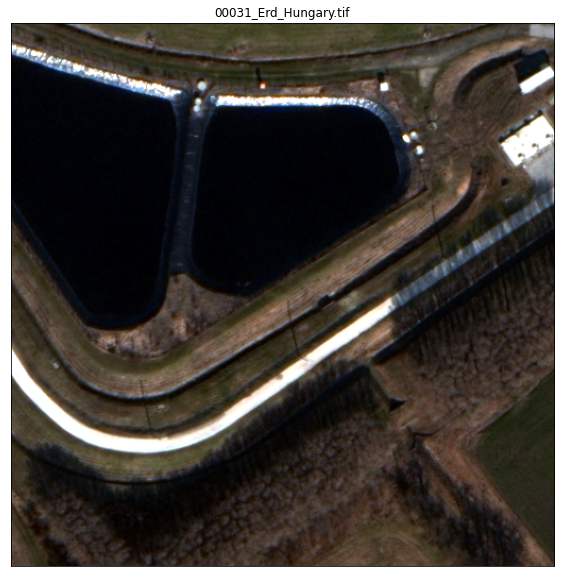

image :  00056_Erd_Hungary.tif channels : 8


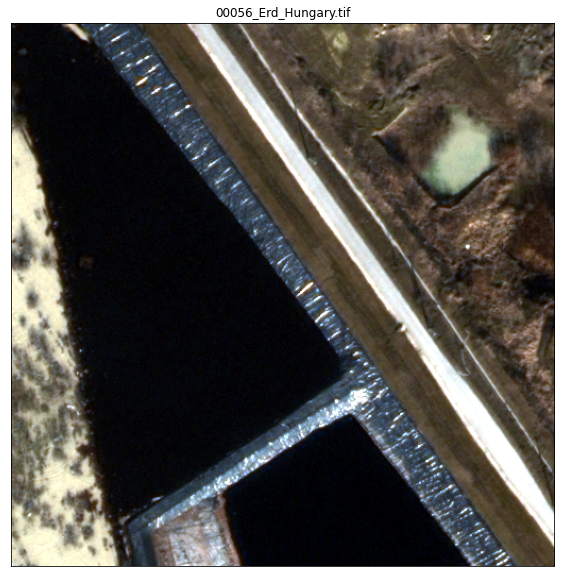

In [17]:
train_files = os.listdir(train_path)

num_of_train_images = len([name for name in train_files if os.path.isfile(os.path.join(train_path, name))])
print("Number of images images:", num_of_train_images)
selected = np.random.choice(num_of_train_images, num_images)

fig = plt.figure(figsize = (25,25))
print('-------------multispectral images----------------')

for i, ind in enumerate(selected):
  raster_arr = rasterio.open(os.path.join(train_path, train_files[ind])).read()
  channels = raster_arr.shape[0]
  print("image : " , train_files[ind], "channels :", channels)
  #false color composite visualisation
  if(channels == 8):
    rgb = (4,2,1)             #R, G, B bands
  elif(channels == 4):
    rgb = (2,1,0)             #R, G, B bands

  ep.plot_rgb(raster_arr, rgb=rgb, stretch=True, title=train_files[ind])
  plt.show()
  #plt.imshow(raster_fcc)
  #plt.title(train_files[ind])

Loading the dataset from the split dataset

referred from:\
https://github.com/tkshnkmr/frcnn_medium_sample,
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Checking the proportion of data classes in the dataset

In [18]:
dataFrame = pd.read_csv(train_labels, usecols=["Idx", "Image Index", "IsLandfill"])
data = dataFrame.values.tolist()
label = pd.read_csv(train_labels, usecols=["IsLandfill"])


def get_class_count(data):
  grp = data.groupby(["IsLandfill"]).nunique()
  return{key : grp[key] for key in list(grp.keys())}

def get_class_proportion(data):
  class_count = get_class_count(data)
  return {val[0]: round(val[1]/data.shape[0], 4) for val in class_count.items()}

#print("Dataset class counts:", get_class_count(dataFrame))
print("Dataset class proportions:", get_class_proportion(dataFrame))

Dataset class proportions: {'Idx': IsLandfill
1    1.0
Name: Idx, dtype: float64, 'Image Index': IsLandfill
1    1.0
Name: Image Index, dtype: float64}


Tackling the imabalanced dataset
1. Undersampling : Randomly delete some observations from the majority class in order to match the numbers with the minority class. Suitable when there is a lot of data
2. Oversampling : Add copies of instances from under-represented class. Suitable for smaller dataset

We will use random over-sampling as we have a small set of data - TBD

Stratified and random split into train, test and validation datasets

In [19]:
train_ratio = 0.70
test_ratio = 0.30
#validation_ratio = 0.10

train_idx, test_idx, train_lab, test_lab = train_test_split(dataFrame, label, 
                                                            test_size = test_ratio, 
                                                            shuffle=True, stratify=label)
"""
train_idx, val_idx, train_lab, val_lab = train_test_split(train_idx, train_lab,
                                                          test_size = validation_ratio,
                                                          shuffle=True, stratify=train_lab)
"""



print("Train size is {}, test size is {}".format(len(train_idx), len(test_idx)))

print("****************Dataset proportion after stratified splitting***************")
print("Train data class proportions:", get_class_proportion(train_idx))
print("Test data class proportions:", get_class_proportion(test_idx))

Train size is 169, test size is 73
****************Dataset proportion after stratified splitting***************
Train data class proportions: {'Idx': IsLandfill
1    1.0
Name: Idx, dtype: float64, 'Image Index': IsLandfill
1    1.0
Name: Image Index, dtype: float64}
Test data class proportions: {'Idx': IsLandfill
1    1.0
Name: Idx, dtype: float64, 'Image Index': IsLandfill
1    1.0
Name: Image Index, dtype: float64}


In [20]:
#parameters
batch_size = 5
num_workers = 1
num_classes = 2       #landfill or background
epochs = 20
lr = 1e-4
w_decay = 1e-5
momentum = 0.9
step_size = 50
gamma = 0.5
image_size = 512
patch_width = 512
patch_height= 512

Create custom transforms to perform data augmentation in the class

In [21]:
class CustomLandfillDataset(torch.utils.data.Dataset):
  def __init__(self, data, transforms=None, num_classes=num_classes):                             #transforms
    self.data = data
    #self.transforms = transforms
    self.json_frame = pd.read_csv(train_labels, usecols=["json index"])
    self.isLandfillList = pd.read_csv(train_labels, usecols=["IsLandfill"]).values.tolist()
    self.num_classes = num_classes

  def transform(self, image, mask):
    #convert image and mask to PIL Images
    mask = TF.to_pil_image(mask)
    image = Image.fromarray(image, "RGB")
    #npimg = np.asarray(image)    

    #random horizontal flip
    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    #random vertical flip
    if random.random() > 0.5:
      image = TF.vflip(image)
      mask = TF.vflip(mask)

    #random rotation
    image = TF.rotate(image, angle=10.0)
    mask = TF.rotate(mask, angle=10.0)

    #Gaussian Blur
    image = TF.gaussian_blur(image, kernel_size=(3,3))
    
    #convert PIL image and mask to tensor before returning
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)
    imgnz = torch.count_nonzero(image > 1.)
    masknz = torch.count_nonzero(mask)
    #print("image:",imgnz)
    
    #normalise the image as per mean and std dev
    #for ImageNet pre-trained
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    #for solaris pre-trained
    #image = TF.normalize(image, mean=[0.006479, 0.009328, 0.01123],
    #                            std=[0.004986, 0.004964, 0.004950])

    return image, mask

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #image id
    img_id = self.data[index][0]
    #path for image
    img_name = self.data[index][1]
    #read the image to extract number of channels
    raster_img = rasterio.open(os.path.join(train_path, img_name)).read()
    #change datatype of image from uint16 to int32
    raster_img = raster_img.astype('uint8')
    #print(raster_img.shape)
    raster_channels = raster_img.shape[0]
    #mask
    json_list = self.json_frame.values.tolist()
    json_name = json_list[img_id-1][0]
    IsLandfill = self.isLandfillList[img_id-1][0]
    if(IsLandfill):
      fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(json_path, json_name), 
                                               reference_im=os.path.join(train_path, img_name))
      fp_mask = fp_mask.astype('uint8')
    else:
      fp_mask = np.zeros((patch_height, patch_width), dtype=np.uint8)

    rgb_image = raster_img.transpose(1,2,0)         
    if(raster_channels == 8):
      rgb_image = np.dstack((raster_img[4,:,:], 
                             raster_img[2,:,:], 
                             raster_img[1,:,:]))
    elif(raster_channels == 4):
      rgb_image = np.dstack((raster_img[2,:,:], 
                             raster_img[1,:,:], 
                             raster_img[0,:,:]))
      

    min = np.min(rgb_image)
    max = np.max(rgb_image)
    #before normalisation, the image should be brought into a 0 - 1 range (standardisation)
    #rgb_image = ((rgb_image - min) / (max - min))     #.astype('uint8')
    rgb_image = rgb_image.astype('uint8')
    #print("raster image-before:",rgb_image)
    
    #print(image.shape, fp_mask.shape)
    rgb_image, fp_mask = self.transform(rgb_image, fp_mask)
    rgb_image_resized = rgb_image.detach().numpy()
    #print("raster image-after:",rgb_image)

    #in case the image is smaller than 512x512
    if((rgb_image.shape[1] < patch_height) or (rgb_image.shape[2] < patch_width)):
      rgb_image_resized = np.zeros((patch_height, patch_width), dtype=np.uint8)
      rgb_image_resized[0:rgb_image.shape[1], 0:rgb_image.shape[2]] = rgb_image[0,:,:]
      rgb_image_resized = np.expand_dims(rgb_image_resized, axis=0)
      for c in range(rgb_image.shape[0]-1):
        resized_raster = np.zeros((patch_height, patch_width), dtype=np.uint8)
        resized_raster[0:rgb_image.shape[1], 0:rgb_image.shape[2]] = rgb_image[c+1,:,:]
        resized_raster = np.expand_dims(resized_raster,axis=0)
        rgb_image_resized = np.vstack((rgb_image_resized, resized_raster)) 

    #rgb_image_resized = rgb_image_resized.astype('uint8')
    #create another mask variable

    mask = fp_mask
    mask = mask.detach().numpy().squeeze()

    #in case the mask size is smaller than 512x512
    if((fp_mask.shape[1] < patch_height) or (fp_mask.shape[2] < patch_width)):
      mask = np.zeros((patch_height, patch_width), dtype=np.int8)
      mask[0:fp_mask.shape[1], 0:fp_mask.shape[2]] = fp_mask
    #one hot encoding of the mask depending on the number of classes
    mask_hotEnc = torch.zeros(self.num_classes, patch_height, patch_width)
    for n in range(self.num_classes):
      mask_hotEnc[n][mask==n] = 1

    #print("resized image:",rgb_image_resized)
    rgb_image_resized = rgb_image_resized.astype('float32')
    mask = mask.astype('float32')
    mask_hotEnc = mask_hotEnc.detach().numpy().astype('float32')

    img_info = {}
    img_info["RGBimage"] = rgb_image_resized
    img_info["mask"] = mask
    img_info["maskHotEnc"] = mask_hotEnc
    img_info["channels"] = raster_channels
    img_info["name"] = img_name
    img_info["image_id"] = img_id

    return img_info

Create respective train and test datasets and create a dataloader

In [22]:
#train_idx and test_idx are dataframes
train_dataset = CustomLandfillDataset(data=train_idx.values.tolist(), transforms=None)                               
test_dataset = CustomLandfillDataset(data=test_idx.values.tolist(), transforms=None)                                

#data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

print("length of training dataset:", len(train_dataset))
print("length of test dataset:", len(test_dataset))
print("length of training loader:", len(train_loader))
print("length of test loader:", len(test_loader))

length of training dataset: 169
length of test dataset: 73
length of training loader: 34
length of test loader: 15


Checking out some images and their corresponding masks

In [23]:
img_info = next(iter(train_loader))

rgb_img = img_info['RGBimage']
mask = img_info['mask']
mask_hotEnc = img_info['maskHotEnc']
channels = img_info['channels']

print("image mask:", mask.shape, "channels:", channels)
print("transformed image shape:", rgb_img.shape, "hot encoded mask:", mask_hotEnc.shape)
print("image dtype:", rgb_img.dtype, " mask dtype:", mask.dtype, " hot encoded dtype:", mask_hotEnc.dtype)
#check the min and max values of the image and mask to check if it is standardised and normalised
rgbArr = rgb_img[0].detach().numpy()
maskArr = mask_hotEnc[0].detach().numpy()
print("Min value of image:", np.min(rgbArr), " Max value of image:", np.max(rgbArr))
print("Min value of mask:", np.min(maskArr), " Max value of mask:", np.max(maskArr))

image mask: torch.Size([5, 512, 512]) channels: tensor([8, 8, 4, 4, 8])
transformed image shape: torch.Size([5, 3, 512, 512]) hot encoded mask: torch.Size([5, 2, 512, 512])
image dtype: torch.float32  mask dtype: torch.float32  hot encoded dtype: torch.float32
Min value of image: -2.117904  Max value of image: 2.6051416
Min value of mask: 0.0  Max value of mask: 1.0


In [24]:
test_info = next(iter(test_loader))

rgb_img = img_info['RGBimage']
mask = img_info['mask']
mask_hotEnc = img_info['maskHotEnc']
channels = img_info['channels']

print("image mask:", mask.shape, "channels:", channels)
print("transformed image shape:", rgb_img.shape, "hot encoded mask:", mask_hotEnc.shape)
#check the min and max values of the image and mask to check if it is standardised and normalised
rgbArr = rgb_img[0].detach().numpy()
maskArr = mask_hotEnc[0].detach().numpy()
print("Min value of image:", np.min(rgbArr), " Max value of image:", np.max(rgbArr))
print("Min value of mask:", np.min(maskArr), " Max value of mask:", np.max(maskArr))

image mask: torch.Size([5, 512, 512]) channels: tensor([8, 8, 4, 4, 8])
transformed image shape: torch.Size([5, 3, 512, 512]) hot encoded mask: torch.Size([5, 2, 512, 512])
Min value of image: -2.117904  Max value of image: 2.6051416
Min value of mask: 0.0  Max value of mask: 1.0


Draw polygon on image:


tensor(182925)
tensor(31163)
tensor(71689)
tensor(134120)
tensor(46345)


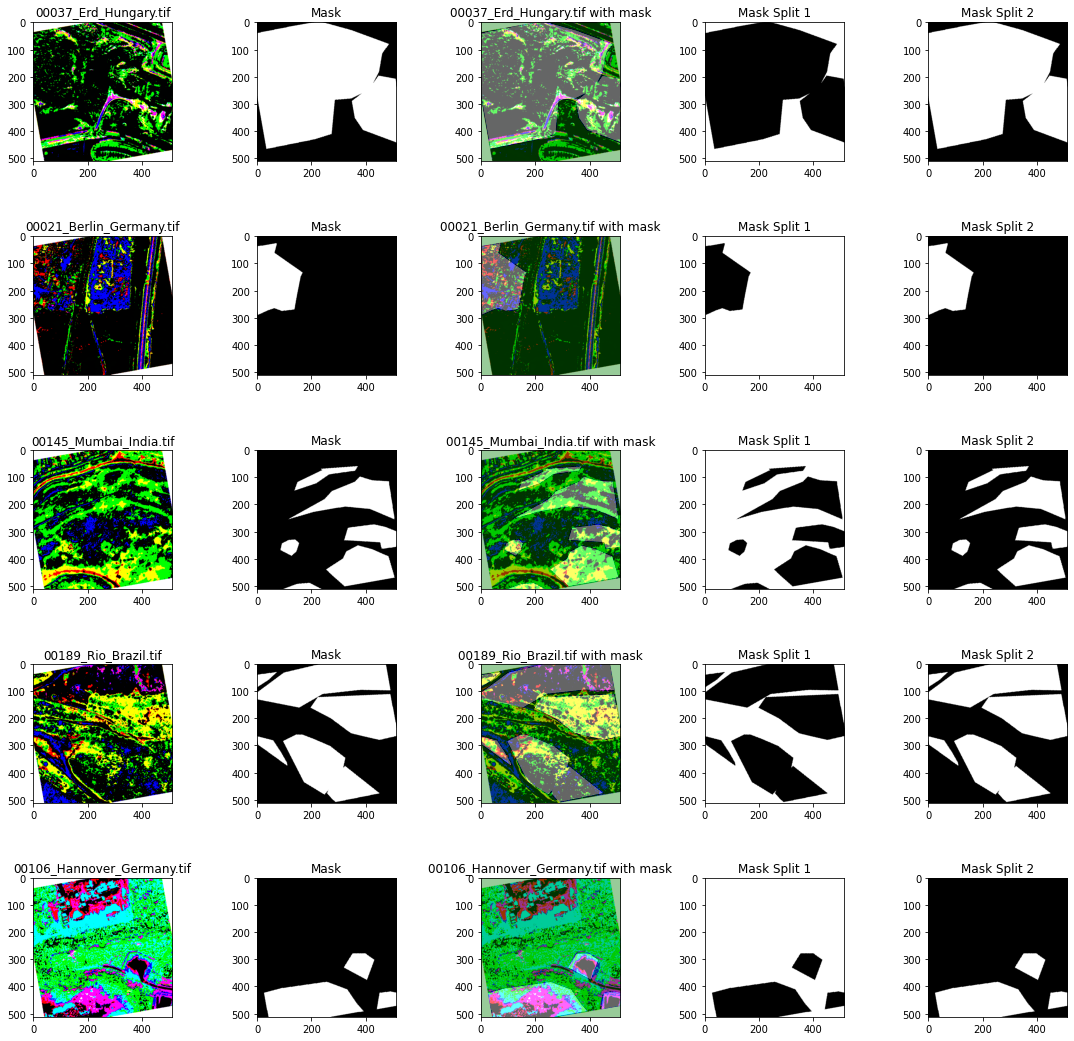

In [25]:
count = 0
fig, axs = plt.subplots(batch_size, 5, figsize = (15, 15))

json_frame = pd.read_csv(train_labels, usecols=["json index"])
json_list = json_frame.values.tolist()

for idx in np.arange(batch_size):
  id = img_info["image_id"][idx].item()
  #print(id)
  json_name = json_list[id-1][0]
  name = img_info["name"][idx]
  #print(name)
  channels = img_info["channels"][idx].item()  
  #image = im_convert(name, channels)
  image = img_info["RGBimage"][idx].detach().numpy()
  image = image.transpose(1,2,0)
  #print(image.shape)
  #print(image)
  image = image.astype('uint8')
  mask = img_info["mask"][idx].detach().numpy()
  #print(mask)
  mask_idx = (img_info["mask"][idx] == 1).sum()
  print(mask_idx)

  maskHotEnc = img_info["maskHotEnc"][idx].detach().numpy()
  #print(maskHotEnc.shape)
  maskHotEnc_split = np.vsplit(maskHotEnc, 2)
  #print(maskHotEnc_split[0].shape)
  axs[count][0].title.set_text(name)
  axs[count][0].imshow(image)

  axs[count][1].title.set_text('Mask')
  axs[count][1].imshow(mask, cmap='gray')

  axs[count][2].title.set_text(name+" with mask")
  axs[count][2].imshow(image)
  axs[count][2].imshow(mask, cmap='ocean', alpha=0.4)

  axs[count][3].title.set_text('Mask Split 1')
  axs[count][3].imshow(maskHotEnc_split[0].transpose(1,2,0).squeeze(), cmap='gray')

  axs[count][4].title.set_text('Mask Split 2')
  axs[count][4].imshow(maskHotEnc_split[1].transpose(1,2,0).squeeze(), cmap='gray')


  count += 1

fig.tight_layout()
  

Plot test loader images and masks

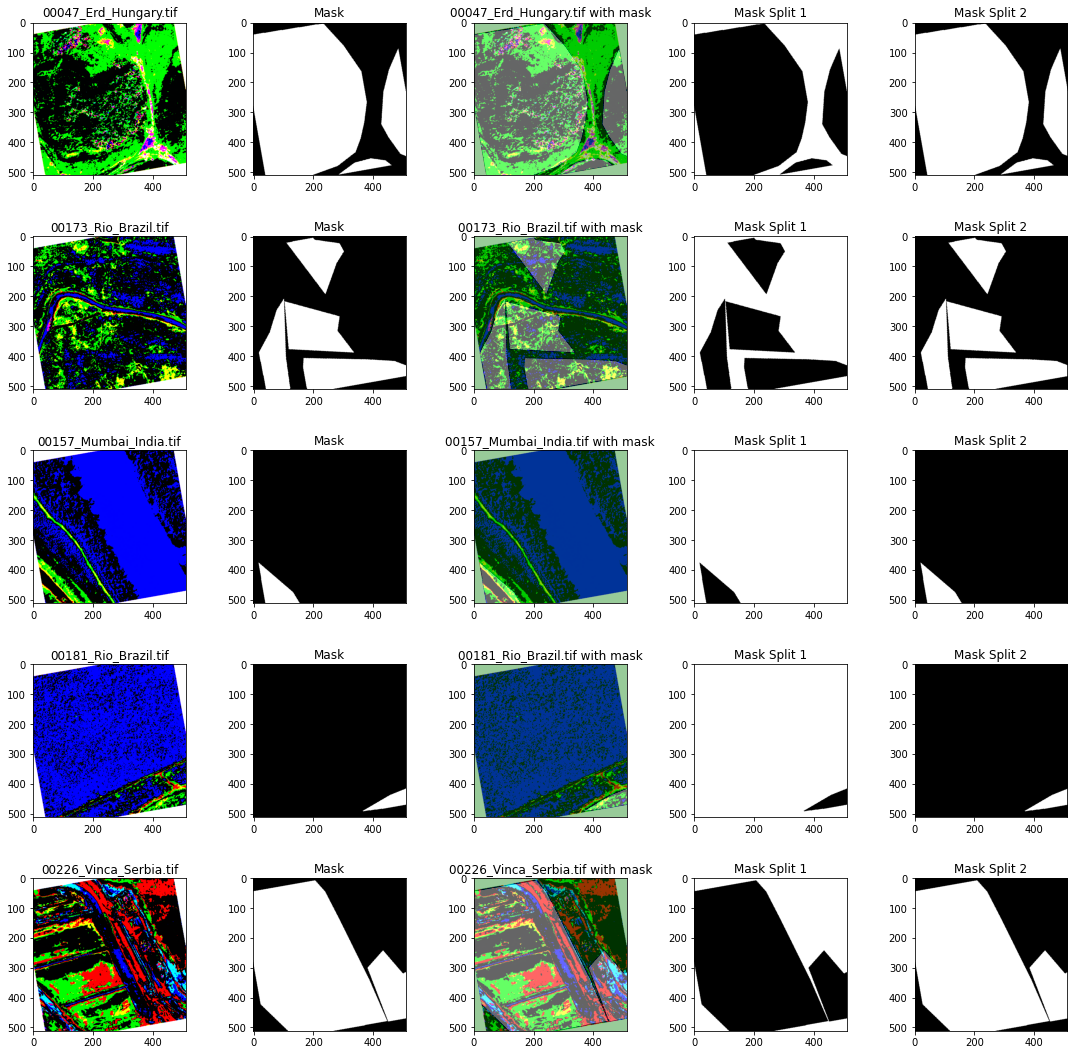

In [26]:
count = 0
fig, axs = plt.subplots(batch_size, 5, figsize = (15, 15))


for idx in np.arange(batch_size):
  id = test_info["image_id"][idx].item()
  #print(id)
  json_name = json_list[id-1][0]
  name = test_info["name"][idx]
  #print(name)
  channels = test_info["channels"][idx].item()  
  #image = im_convert(name, channels)
  image = test_info["RGBimage"][idx].detach().numpy()
  image = image.transpose(1,2,0)
  image = image.astype('uint8')
  mask = test_info["mask"][idx].detach().numpy()
  maskHotEnc = test_info["maskHotEnc"][idx].detach().numpy()
  #print(maskHotEnc.shape)
  maskHotEnc_split = np.vsplit(maskHotEnc, 2)
  #print(maskHotEnc_split[0].shape)
  axs[count][0].title.set_text(name)
  axs[count][0].imshow(image)

  axs[count][1].title.set_text('Mask')
  axs[count][1].imshow(mask, cmap='gray')

  axs[count][2].title.set_text(name+" with mask")
  axs[count][2].imshow(image)
  axs[count][2].imshow(mask, cmap='ocean', alpha=0.4)

  axs[count][3].title.set_text('Mask Split 1')
  axs[count][3].imshow(maskHotEnc_split[0].transpose(1,2,0).squeeze(), cmap='gray')

  axs[count][4].title.set_text('Mask Split 2')
  axs[count][4].imshow(maskHotEnc_split[1].transpose(1,2,0).squeeze(), cmap='gray')


  count += 1

fig.tight_layout()
  

Training a model on the training batches

Freeze the weights until some intermediate layers to finetune the rest of the network\
https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2  \
ref: https://github.com/pochih/FCN-pytorch/tree/8436fab3586f118eb36265dab4c5f900748bb02d

UNet encoder configurations

In [27]:
pretrained = False
remove_fc = False
pretrained_model_path ='./PreTrainedModels/xdxd_spacenet4_solaris_weights.pth'
enc_model = 'SolarisPreTrained'

In [28]:
maxpool_ranges = {
    'vgg11'             : ((0, 21)),
    'vgg13'             : ((0, 25)),
    'vgg16'             : ((0, 31)),        #((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))
    'SolarisPreTrained' : ((0, 31)),
    'vgg19'             : ((0, 37))
}

In [29]:
encoder_copy_crop = {
    'vgg13'             :   ((0, 4), (4, 9), (9, 14), (14, 19), (19, 24)),
    'vgg16'             :   ((0, 4), (4, 9), (9, 16), (16, 23), (23, 30)),
    'SolarisPreTrained' :   ((0, 4), (4, 9), (9, 16), (16, 23), (23, 30))
}

In [30]:
decoder_dimension = {
    'decoder1'    :   ((128, 64), (256, 128), (512, 256), (512, 512), (1024, 512))
}

In [31]:
def load_model(enc_model=enc_model):
  if enc_model == 'vgg11':
    model = models.vgg11(pretrained=pretrained)
  if enc_model == 'vgg13':
    model = models.vgg13(pretrained=pretrained)
  if enc_model == 'vgg16':
    print('---loading vgg16----')
    model = models.vgg16(pretrained=pretrained)
  if enc_model == 'vgg19':
    model = models.vgg19(pretrained=pretrained)
  if enc_model == 'SolarisPreTrained':
    print('---loading solaris pretrained---')   
    model = models.vgg16(pretrained=pretrained)
    del model.avgpool
    del model.classifier
    pretrained_dict = torch.load(pretrained_model_path, map_location='cpu')
    model_dict = model.state_dict()
    new = list(pretrained_dict.items())
    count = 0
    for key, value in model_dict.items():
      layer_name, weights = new[count]
      model_dict[key] = weights
      count += 1
    model.load_state_dict(model_dict, strict=False)
  return model

In [32]:
class DecoderBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
  
  def forward(self, x):
    return self.relu(self.conv2(self.relu(self.conv1(x))))

UNet model with encoder selected from encoder routine

In [33]:
class UNet(nn.Module):
  def __init__(self, pretrained=pretrained, enc_model=enc_model, requires_grad=True, remove_fc=remove_fc, num_classes=num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.encoder_copy_crop =  encoder_copy_crop[enc_model]
    self.maxpool_ranges = maxpool_ranges[enc_model]
    self.decoder = decoder_dimension['decoder1']
    #encoder
    self.enc_model = load_model(enc_model=enc_model)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    #use this piece of code to freeze and unfreeze layers for training

    cnt = 0
    for child in self.enc_model.children():
        for name, param in child.named_parameters():
          if cnt < 4:
            param.requires_grad = False
          cnt += 1


    if requires_grad ==  False:
      for param in self.enc_model.parameters():
        param.requires_grad = False

    if remove_fc:
      del self.enc_model.avgpool
      del self.enc_model.classifier

    print("******************encoder model************")
    print(self.enc_model)
    #center
    self.center_conv1 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
    self.center_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
    #decoder
    self.up_conv5 = nn.ConvTranspose2d(self.decoder[4][0], self.decoder[4][1], 
                                       kernel_size=3, stride=2, padding=1, 
                                       dilation=1, output_padding=1)
    self.dec5 = DecoderBlock(self.decoder[4][0], self.decoder[4][1])
    self.up_conv4 = nn.ConvTranspose2d(self.decoder[3][0], self.decoder[3][1],    
                                       kernel_size=3, stride=2, padding=1, 
                                       dilation=1, output_padding=1)
    self.dec4 = DecoderBlock(self.decoder[4][0], self.decoder[4][1])              #1024, 512
    self.up_conv3 = nn.ConvTranspose2d(self.decoder[2][0], self.decoder[2][1], 
                                       kernel_size=3, stride=2, padding=1, 
                                       dilation=1, output_padding=1)
    self.dec3 = DecoderBlock(self.decoder[2][0], self.decoder[2][1])
    self.up_conv2 = nn.ConvTranspose2d(self.decoder[1][0], self.decoder[1][1], 
                                       kernel_size=3, stride=2, padding=1, 
                                       dilation=1, output_padding=1)
    self.dec2 = DecoderBlock(self.decoder[1][0], self.decoder[1][1])
    self.up_conv1 = nn.ConvTranspose2d(self.decoder[0][0], self.decoder[0][1], 
                                       kernel_size=3, stride=2, padding=1, 
                                       dilation=1, output_padding=1)
    self.dec1 = DecoderBlock(self.decoder[0][0], self.decoder[0][1])
    #final layer
    self.final = nn.Conv2d(self.decoder[0][1], num_classes, kernel_size=1)


  def encoder_cpycrop(self, x):
    output = {}
    for idx in range(len(self.encoder_copy_crop)):
      for layer in range(self.encoder_copy_crop[idx][0], self.encoder_copy_crop[idx][1]):
        x = self.enc_model.features[layer](x)
      output['e%d'%(idx+1)] = x
    return output

  def encoder_output(self, x):
    output = {}
    #for idx in range(len(self.maxpool_ranges)):
    idx = 0
    for layer in range(self.maxpool_ranges[0], self.maxpool_ranges[1]):
      x = self.enc_model.features[layer](x)
    output['x%d'%(idx+1)] = x
    return output

  def forward(self, x):
    enc = self.enc_model.features(x)
    #print(enc.shape)
    cpycrop = self.encoder_cpycrop(x)
    e1 = cpycrop['e1']
    e2 = cpycrop['e2']
    e3 = cpycrop['e3']
    e4 = cpycrop['e4']
    e5 = cpycrop['e5']

    output = self.encoder_output(x)
    #print(encoder_output)
    x1 = output['x1']
    #x5 = self.enc_model(x)

    #center
    score = self.relu(self.center_conv2(self.relu(self.center_conv1(enc))))
    #decoder
    score = torch.cat((self.up_conv5(score), e5), 1)
    #print("score5:",score.shape)
    score = self.dec5(score)
    #print("dec5:",score.shape) 

    score = torch.cat((self.up_conv4(score), e4), 1)
    #print("score4:",score.shape)
    score = self.dec4(score)
    #print("dec4:",score.shape)

    score = torch.cat((self.up_conv3(score), e3), 1)
    #print("score3:",score.shape)   
    score = self.dec3(score)
    #print("dec3:",score.shape)   

    score = torch.cat((self.up_conv2(score), e2), 1)
    #print("score2:",score.shape)
    score = self.dec2(score)
    #print("dec2:",score.shape)

    score = torch.cat((self.up_conv1(score), e1), 1)
    #print("score1:",score.shape)
    score = self.dec1(score)
    #print("dec1:",score.shape)
    #final layer
    score = self.final(score)
    return score

In [34]:
UNet_model = UNet(pretrained=pretrained, enc_model=enc_model, remove_fc=remove_fc, num_classes=num_classes)
for name, param in UNet_model.named_parameters():
  if param.requires_grad == True:
    print(name, "\t", param.size())

UNet_model = UNet_model.to(device)

---loading solaris pretrained---
******************encoder model************
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inp

Loss and optimiser

In [35]:
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.SGD(UNet_model.parameters(), lr=lr, momentum=momentum)     #, 
#scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [36]:
def modelPath(enc_model=enc_model):
  if(enc_model == 'vgg11'):
    model_path = './vgg_11_UNet.pth'
  if(enc_model == 'vgg13'):
    model_path = './vgg_13_UNet.pth'
  if(enc_model == 'vgg16'):
    model_path = './vgg_16_UNet.pth'
  if(enc_model == 'vgg19'):
    model_path = './vgg_19_UNet.pth'
  if(enc_model == 'SolarisPreTrained'):
    model_path = './Solaris_vgg16_UNet.pth'

  return model_path

K-fold prep

In [37]:
#https://github.com/pochih/FCN-pytorch/blob/8436fab3586f118eb36265dab4c5f900748bb02d/python/train.py
model_path = modelPath(enc_model)
score_dir = './'

IU_scores    = np.zeros((epochs, num_classes))
pixel_scores = np.zeros(epochs)
val_losses_min = []
ious_mean = []
train_iou_mean = []
train_precision_mean = []
train_recall_mean = []
train_specificity_mean = []
val_precision_mean = []
val_recall_mean = []
val_specificity_mean = []
val_kappa_mean = []
ious_ = []
pixel_accs = []
train_losses = []
val_losses = []
accuracy = []
pixelAccs_mean = []

def TrainFunction():
  for epoch in range(epochs):
    train_loss = 0.0
    training_accuracy = 0.0
    total_train = 0.0
    correct_train = 0.0
    total_val = 0.0
    correct_val = 0.0
    val_accuracy = 0.0
    val_loss = 0.0
    trainIoU = 0.0
    iouVal = 0.0
    precisionVal = 0.0
    recallVal = 0.0
    specificityVal = 0.0
    kappaVal = 0.0
    train_ious = []
    total_ious = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_kappa = []

    t0 = time.time()
    UNet_model.train()
    for batch, img_info in enumerate(train_loader):
      rgb_img = img_info['RGBimage']
      #print("rgb_img:",rgb_img.shape)
      #print(rgb_img)
      mask_hotEnc = img_info['maskHotEnc']
      target = img_info['mask']
      rgb_img = rgb_img.to(device)
      mask_hotEnc = mask_hotEnc.to(device)
      target = target.to(device)
      outputs = UNet_model(rgb_img)
      #print("outputs:",outputs)
      loss = criterion(outputs, mask_hotEnc)
      train_loss += loss.item()*rgb_img.size(0)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #training performance metrics
      _, predicted = torch.max(outputs, 1)  
      #print("predicted:",predicted)
      total_train += target.nelement()
      for p, t in zip(predicted, target):
        correct_train += (p == t).sum()
        train_ious.append(iou(p, t))

    #print("total_train:", total_train)
    train_ious = np.array(train_ious).T
    trainIoU = np.nanmean(train_ious)
    train_iou_mean.append(trainIoU)
    training_accuracy = 100*(correct_train / total_train)
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    accuracy.append(training_accuracy.item())
      
    UNet_model.eval()
    with torch.no_grad():
      for batch, img_info in enumerate(test_loader):
        rgb_img = img_info['RGBimage']
        mask_hotEnc = img_info['maskHotEnc']
        target = img_info['mask']
        rgb_img = rgb_img.to(device)
        mask_hotEnc = mask_hotEnc.to(device)
        target = target.to(device)
        outputs = UNet_model(rgb_img)
        #print("outputs:",outputs)
        loss = criterion(outputs, mask_hotEnc)
        val_loss += loss.item()*rgb_img.size(0)
          
        _, predicted = torch.max(outputs, 1)
        #print("predicted:",predicted)
        total_val += target.nelement()
        #determine performance metrics
        #a. Overall Accuracy
        for p, t in zip(predicted, target):
          correct_val += (p == t).sum()
          #ious are calculated for each class separately and then averaged over all classes
          #to provide global, mean IoU score of our semantic segmentation prediction
          total_ious.append(iou(p, t))
          #print("predicted 1s:", torch.count_nonzero(p==1))
          #print("target 1s:", torch.count_nonzero(t==1))
          precisionVal, recallVal, specificityVal, kappaVal = ConfusionMatrixComponents(p, t)
          val_precision.append(precisionVal)
          val_recall.append(recallVal)
          val_specificity.append(specificityVal)
          val_kappa.append(kappaVal)

      total_ious = np.array(total_ious).T
      #print(total_ious)
      iouVal = np.nanmean(total_ious)
      ious_mean.append(iouVal)
      val_precision_mean.append(np.mean(val_precision))
      val_recall_mean.append(np.mean(val_recall))
      val_specificity_mean.append(np.mean(val_specificity))
      val_kappa_mean.append(np.mean(val_kappa))
      val_accuracy = 100 * (correct_val / total_val)
      val_loss = val_loss/len(test_loader.sampler)
      pixelAccs_mean.append(val_accuracy)
      val_losses.append(val_loss)
      print("epoch: {}/{}, Training Loss in epoch:{}, validation loss: {}, training accuracy:{}, validation accuracy: {}, time elapsed: {}".format(epoch, 
                                                                                                    epochs, train_loss, val_loss, training_accuracy, val_accuracy,
                                                                                                    time.time() - t0))
      print("Background and landfill IoUs for epoch {}/{}, Training IoU:{}, Validation IoU:{}".format(epoch, epochs, trainIoU, iouVal))
      print("Validation Precision:{}%, Validation Recall:{}%, Validation Specificity:{}%, Validation Kappa:{}".format(np.mean(val_precision)*100, 
                                                                                                                      np.mean(val_recall)*100, 
                                                                                                                      np.mean(val_specificity)*100,
                                                                                                                      np.mean(val_kappa)))
      print("Saving model----->")
      torch.save(UNet_model.state_dict(), model_path)
    #scheduler.step()
  print("Mean Validation Precision:{}%, Mean Validation Recall:{}%, Mean Validation Specificity:{}, Mean Kappa Value:{}".format(np.nanmean(val_precision_mean)*100, 
                                                                                                            np.nanmean(val_recall_mean)*100, 
                                                                                                            np.nanmean(val_specificity_mean)*100,
                                                                                                            np.nanmean(val_kappa_mean)))
  #Final mean IOU, 
  print("Mean Training IOU:{}%, Mean Validation IOU:{}%:".format(np.nanmean(train_iou_mean)*100, np.nanmean(ious_mean)*100))


Common semantic segmentation performance metrics

In [38]:
def iou(pred, target):
  ious = []
  for cls in range(num_classes):
    pred_inds = (pred == cls)
    target_inds = (target == cls)
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if(union == 0):
      ious.append(float('nan'))
    else:
      iou = float(intersection) / max(union, 1)
      ious.append(iou.detach().cpu().numpy())
  #print(ious)
  return ious

In [39]:
def ConfusionMatrixComponents(pred, target):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  precision = 0.0
  recall = 0.0
  specificity = 0.0
  kappa = 0.0
  #1 is positive class, 0 is negative class

  pred_tp_idx = (pred == 1)
  target_tp_idx = (target == 1)
  tp = pred_tp_idx[target_tp_idx].sum()

  pred_tn_idx = (pred == 0)
  target_tn_idx = (target == 0)
  tn = pred_tn_idx[target_tn_idx].sum()

  pred_fp_idx = (pred == 1)
  target_fp_idx = (target == 0)
  fp = pred_fp_idx[target_fp_idx].sum()

  pred_fn_idx = (pred == 0)
  target_fn_idx = (target == 1)
  fn = pred_fn_idx[target_fn_idx].sum()

  print("tp:{}, tn:{}, fp:{}, fn:{}".format(tp, tn, fp, fn))

  #precision 
  precision = tp / ( tp + fp )
  precision = precision.detach().cpu().numpy()
  #recall/sensitivity
  recall = tp / (tp + fn)
  recall = recall.detach().cpu().numpy()
  #specificity
  specificity = tn / (tn + fp)
  specificity = specificity.detach().cpu().numpy()

  total_obs = (tp+fp+tn+fn)
  observed_agg = (tp+tn)/total_obs
  correct_obs = ((tp+fp)*(tp+fn))/total_obs
  incorrect_obs = ((tn+fn)*(tn+fp))/total_obs
  expected_agg = correct_obs + incorrect_obs
  kappa = (observed_agg - expected_agg)/(1-expected_agg)
  kappa = kappa.detach().cpu().numpy()
  #print(precision, recall, specificity, kappa)
  return precision, recall, specificity, kappa

In [ ]:
TrainFunction()

In [ ]:
def PlotLoss(train_loss, val_loss):
  print('****Loss Plot********')
  plt.plot(train_loss, label='Training loss')
  plt.plot(val_losses, label = 'Validation loss')
  plt.title('Loss plot')
  plt.legend()

In [ ]:
def PlotAccuracy(train_accuracy, val_accuracy):
  plt.plot(accuracy, label='Training pixel accuracy')
  plt.plot(pixelAccs_mean, label='Validation pixel accuracy')
  plt.title('Accuracy plot')
  plt.legend()

In [ ]:
def PlotIoU(train_iou_mean, ious_mean):
  plt.plot(train_iou_mean, label='Training IoU')
  plt.plot(ious_mean, label='Validation IoU')
  plt.title('IoU plot')
  plt.legend()

In [ ]:
def ROC(specificity, recall):
  x = np.linspace(0,1,50)
  y = x
  plt.plot(x,y,'k-')
  plt.plot(specificity, recall)
  plt.xlabel('Specificity')
  plt.ylabel('Recall')
  plt.title('ROC')
  plt.legend()

In [ ]:
def PrecisionRecall(precision, recall):
  plt.plot(recall, precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend()

In [ ]:
PlotLoss(train_losses, val_losses)

In [ ]:
PlotAccuracy(accuracy, pixelAccs_mean)

In [ ]:
PlotIoU(train_iou_mean, ious_mean)

We plot ROC over precision-recall becauase we have more background pixels as compared to the landfill pixels. Precision is more focussed on positive class than on the negative class and it actually measures the probablity of correct detection of positive values. ROC curve on the other hand meaures the ability to distinguish between classes and hence is a better measure for imbalanced classes